https://github.com/timsainb/tensorflow2-generative-models/blob/master/3.0-WGAN-GP-fashion-mnist.ipynb



## Setup

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
keras.backend.clear_session()
tf.__version__

'2.2.0-rc4'

## WGAN

In [0]:
class WGAN(keras.Model):
  def __init__(self, discriminator, generator, latent_dim, gradient_penalty_weight):
    super(WGAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim
    self.gradient_penalty_weight = gradient_penalty_weight

  def compile(self, d_optimizer, g_optimizer):
    super(WGAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer

  def generate(self,z): 
    return self.generator(z)

  def discriminate(self,imgs):
    return self.discriminator(imgs)

  def gradient_penalty(self, x, x_gen):
    epsilon = tf.random.uniform([tf.shape(x)[0], 1, 1, 1], 0.0, 1.0)
    x_hat = epsilon * x + (1 - epsilon) * x_gen
    with tf.GradientTape() as t:
        t.watch(x_hat)
        d_hat = self.discriminate(x_hat)
    gradients = t.gradient(d_hat, x_hat)
    ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1,2])+ 1e-12) #  1e-12 is for stability
    d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
    return d_regularizer

  def train_step(self, real_images):
    # Sample random points in the latent space
    batch_size = tf.shape(real_images)[0]

    #Train Critic 5 times
    for _ in range(5):
      with tf.GradientTape() as disc_tape:
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generate(random_latent_vectors)

        # Get the outputs for real and fake images
        disc_real = self.discriminate(real_images)
        disc_fake = self.discriminate(generated_images)

        # Get the loss going
        grad_pen = self.gradient_penalty(real_images, generated_images)
        disc_loss = - tf.reduce_mean(disc_real) + tf.reduce_mean(disc_fake) + grad_pen * self.gradient_penalty_weight

      # Train the discriminator
      d_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_weights)
      self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_weights))

    # Train the generator 1 time
    with tf.GradientTape() as gen_tape:
      random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

      # Decode them to fake images
      generated_images = self.generate(random_latent_vectors)

      # Get the outputs for fake images
      disc_fake = self.discriminate(generated_images)        

      # Get the loss going
      gen_loss = - tf.reduce_mean(disc_fake)

    g_grads = gen_tape.gradient(gen_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_weights))

    return {"grad_penalty": grad_pen, 'd_loss': disc_loss, 'g_loss': gen_loss}

In [0]:
TRAIN_BUF=60000
BATCH_SIZE=64
TEST_BUF=10000
DIMS = (28,28,1)
latent_dim = 64
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [0]:
# Create the discriminator
w_critic = keras.Sequential([
  keras.Input(shape=DIMS),
  layers.Conv2D(32, (4, 4), strides=(2, 2), padding='same'),
  layers.LeakyReLU(alpha=0.2),
  layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same'),
  layers.LeakyReLU(alpha=0.2),
  layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'),
  layers.LeakyReLU(alpha=0.2),
  layers.GlobalMaxPooling2D(),
  layers.Dense(units=1)
], name='discriminator')

# Create the generator
generator = keras.Sequential([
  keras.Input(shape=(latent_dim,)),
  # We want to generate 64 coefficients to reshape into a 64 map
  layers.Dense(7 * 7 * latent_dim),
  layers.ReLU(),
  layers.Reshape((7, 7, latent_dim)),
  layers.Conv2DTranspose(latent_dim, (3, 3), strides=(2, 2), padding='same'),
  layers.ReLU(),
  layers.Conv2DTranspose(latent_dim * 2, (3, 3), strides=(2, 2), padding='same'),
  layers.ReLU(),
  layers.Conv2DTranspose(latent_dim * 4, (4, 4), strides=(2, 2), padding='same'),
  layers.ReLU(),
  layers.Conv2D(1, (3, 3), strides=(2, 2), padding='same', activation='sigmoid')
], name='generator')


In [0]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_images = np.reshape(train_images,(-1, 28, 28, 1)).astype(
    "float32"
) / 255.0
test_images = np.reshape(test_images,(-1, 28, 28, 1)).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

In [0]:
gen_optimizer = keras.optimizers.Adam(0.0002, beta_1=0.5)
disc_optimizer = keras.optimizers.Adam(0.0001)
# model
model = WGAN(
    generator = generator,
    discriminator = w_critic,
    latent_dim = latent_dim,
    gradient_penalty_weight = 10.0
)

model.compile(
    d_optimizer=disc_optimizer,
    g_optimizer=gen_optimizer,
)

In [11]:
hist = model.fit(train_dataset, epochs=10)

Epoch 1/10
938/938 [==============================] - 122s 130ms/step - grad_penalty: 0.0399 - d_loss: -2.0316 - g_loss: -0.8868
Epoch 2/10
938/938 [==============================] - 122s 130ms/step - grad_penalty: 0.0122 - d_loss: -1.4381 - g_loss: -3.4071
Epoch 3/10
938/938 [==============================] - 122s 130ms/step - grad_penalty: 0.0104 - d_loss: -1.0740 - g_loss: -0.4740
Epoch 4/10
938/938 [==============================] - 122s 130ms/step - grad_penalty: 0.0075 - d_loss: -0.7734 - g_loss: 0.7216
Epoch 5/10
938/938 [==============================] - 122s 130ms/step - grad_penalty: 0.0061 - d_loss: -0.6670 - g_loss: 2.2559
Epoch 6/10
938/938 [==============================] - 123s 131ms/step - grad_penalty: 0.0061 - d_loss: -0.5909 - g_loss: 2.4141
Epoch 7/10
938/938 [==============================] - 123s 131ms/step - grad_penalty: 0.0055 - d_loss: -0.5355 - g_loss: 0.6391
Epoch 8/10
938/938 [==============================] - 123s 131ms/step - grad_penalty: 0.0054 - d_loss

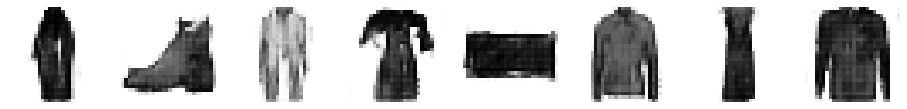

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, latent_dim)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

plot_reconstruction(model)

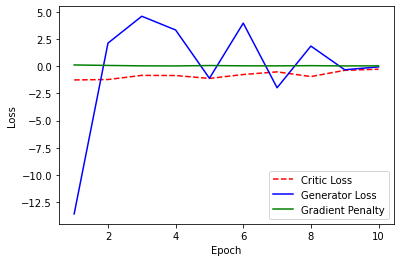

In [13]:
# Get training and test loss histories
g_loss = hist.history['g_loss']
g_penalty = [i*10 for i in hist.history['grad_penalty']]
d_loss = [i-j for i,j in zip(hist.history['d_loss'],g_penalty)]
# Create count of the number of epochs
epoch_count = range(1, len(d_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, d_loss, 'r--')
plt.plot(epoch_count, g_loss, 'b-')
plt.plot(epoch_count, g_penalty, 'g-')

plt.legend(['Critic Loss', 'Generator Loss', 'Gradient Penalty'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();